Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


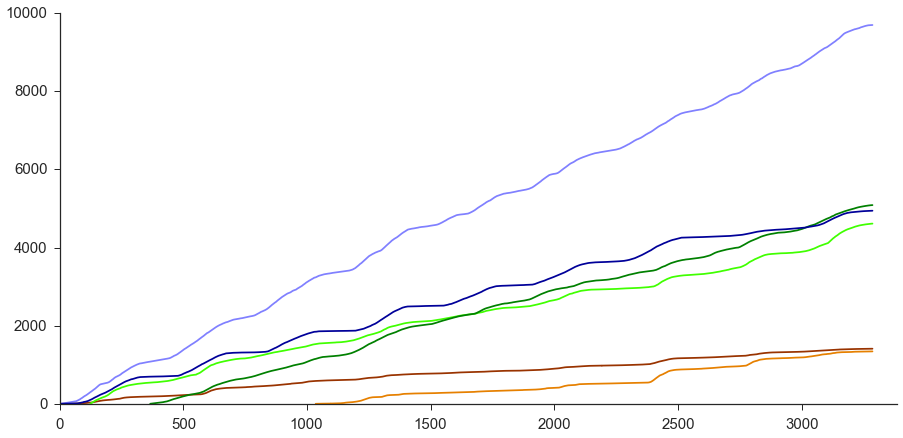

In [202]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
import matplotlib.pyplot as plt

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import pysal as ps 
import gdal

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon as PolygonM

import rasterio
import os
from rasterstats import zonal_stats


# Directory with daily files for the figure
fluxfileDir = 'C:\\Research\\NASA_USDA-NIFA_ROSES_2016\\'

# Color scheme
gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
siteColors = [gcolour, scolour, jcolour, pjcolour, pcolour, mcolour]

# Filenames of each daily file
seg = 'US-Sen_2007_2016_daily.txt'
ses = 'US-Ses_2007_2016_daily.txt'
wjs = 'US-Wjs_2007_2016_daily.txt'

mpj = 'US-Mpj_2007_2016_daily.txt'
vcp = 'US-Vcp_2007_2016_daily.txt'
vcm = 'US-Vcm_2007_2016_daily.txt'

# Read in and concat each file with an extra column, SITE
Seg = pd.read_csv(fluxfileDir + seg, sep = '\t')
Ses = pd.read_csv(fluxfileDir + ses, sep = '\t')
Wjs = pd.read_csv(fluxfileDir + wjs, sep = '\t')

Mpj = pd.read_csv(fluxfileDir + mpj, sep = '\t')
Vcp = pd.read_csv(fluxfileDir + vcp, sep = '\t')
Vcm = pd.read_csv(fluxfileDir + vcm, sep = '\t')
Seg[Seg == -9999] = np.nan

Seg['SITE'] = 'Seg'
Ses['SITE'] = 'Ses'
Wjs['SITE'] = 'Wjs'

Mpj['SITE'] = 'Mpj'
Vcp['SITE'] = 'Vcp'
Vcm['SITE'] = 'Vcm'

# Concatenate files into single pandas df
# then replace -9999 with NaN
fluxdf = pd.concat([Seg, Ses, Wjs, Mpj, Vcp, Vcm])
fluxdf[fluxdf == -9999] = np.nan

# Setup a color palette for the sites
forestTS = ['#d8b365','#91bfdb','#5ab4ac','#d8b365','#91bfdb','#5ab4ac']

# Quick cumulative comparison
f, (ax) = plt.subplots(1,1, figsize = (15, 7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    siteflux = fluxdf[fluxdf.SITE == site]
    siteflux.GPP.cumsum().plot(ax = ax, color = siteColors[idx])
    idx = idx + 1

sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
sns.despine()

In [199]:
fluxdf.SITE.unique()

array(['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], dtype=object)

Mpj 18    2010
Name: year, dtype: int64 796.47010093 36    2013
Name: year, dtype: int64 547.472067963
Seg 37    2013
Name: year, dtype: int64 370.692689394 13    2009
Name: year, dtype: int64 6.329974058
Ses 8    2008
Name: year, dtype: int64 231.64280494 26    2011
Name: year, dtype: int64 78.293081027
Vcm 3    2007
Name: year, dtype: int64 694.41954209 45    2014
Name: year, dtype: int64 202.126472892
Vcp 22    2010
Name: year, dtype: int64 1183.25200203 28    2011
Name: year, dtype: int64 883.42774116
Wjs 53    2015
Name: year, dtype: int64 759.068819671 29    2011
Name: year, dtype: int64 354.211255887


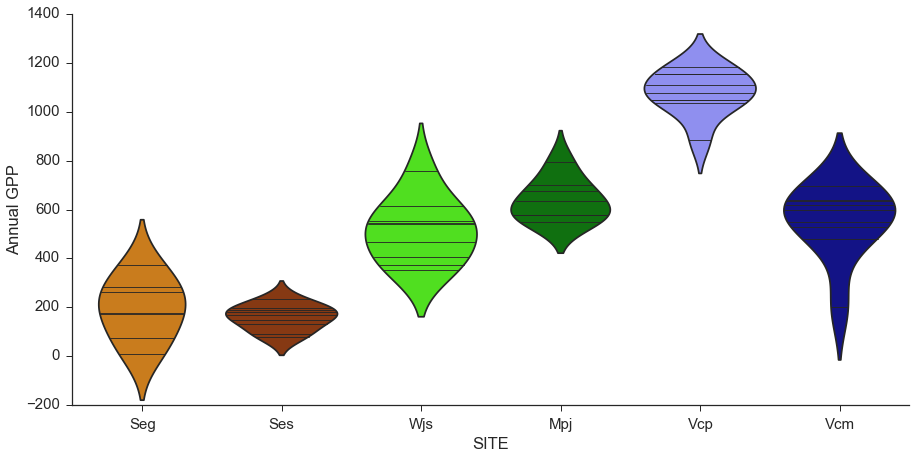

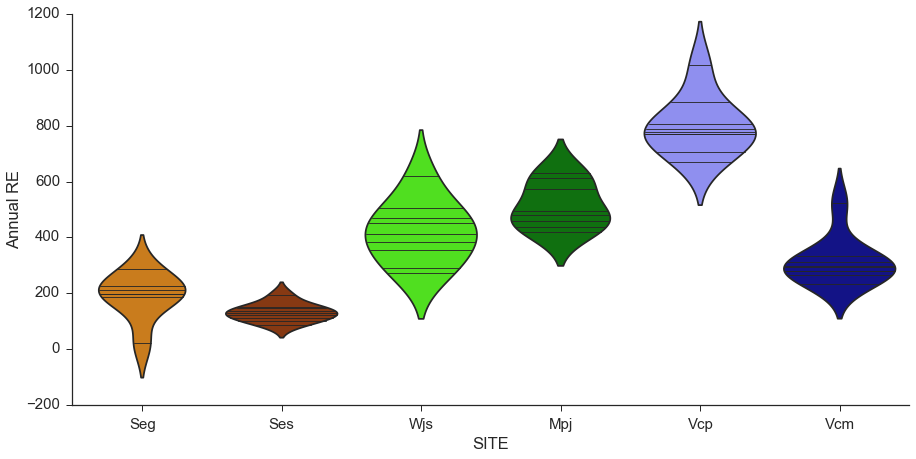

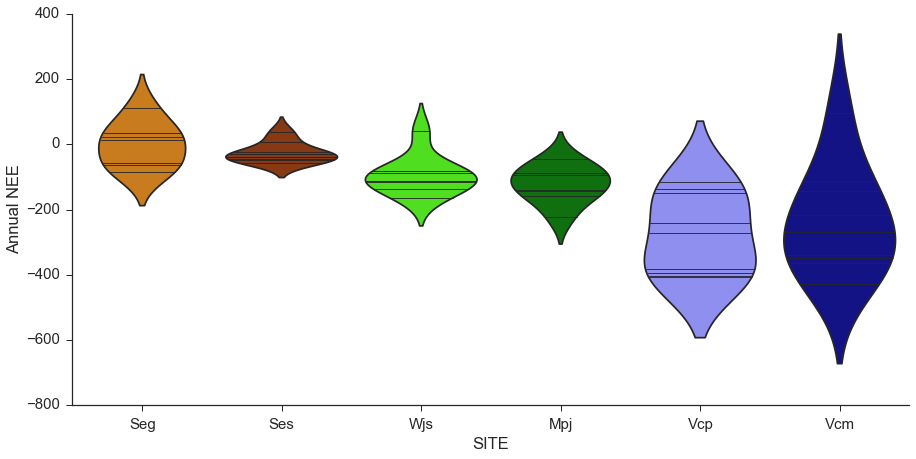

In [190]:
annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()

for site in np.unique(annualSums.SITE):
    maxgpp = annualSums[annualSums.SITE == site].GPP.max()
    mingpp = annualSums[annualSums.SITE == site].GPP.min()
    yearofMax = annualSums[annualSums.GPP == maxgpp].year
    yearofMin = annualSums[annualSums.GPP == mingpp].year
    print site, yearofMax, maxgpp, yearofMin, mingpp
    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="GPP",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual GPP')
sns.despine()

plt.savefig('AnnualGPPDistro.tif')

annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()

    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="RECO",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual RE')
sns.despine()

plt.savefig('AnnualREDistro.tif')

annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()
    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="FC_F",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual NEE')
sns.despine()

plt.savefig('AnnualNEEDistro.tif')

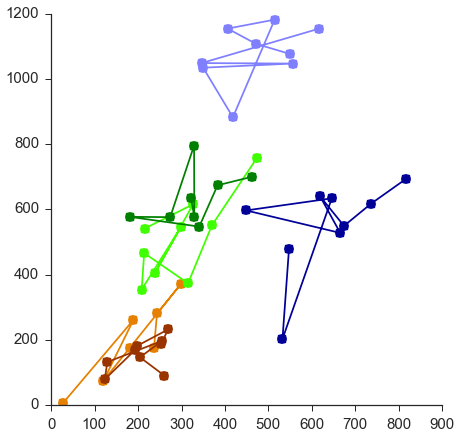

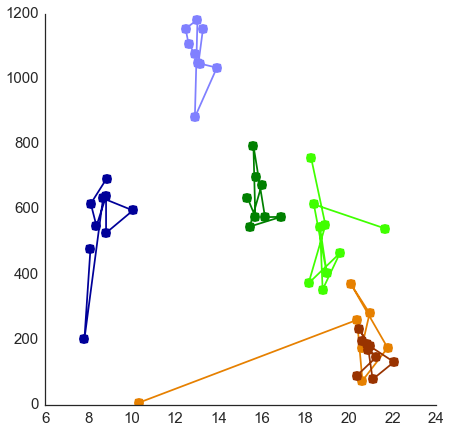

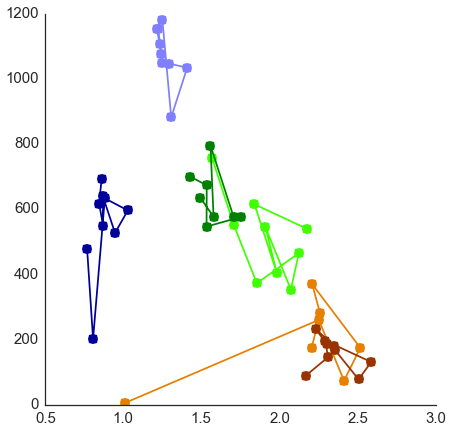

In [191]:
f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    siteflux = annualSums[annualSums.SITE == site]
    ax1.plot(siteflux['P_F'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxPRECIP.tif')

f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    sitefluxM = annualMeans[annualMeans.SITE == site]
    siteflux = annualSums[annualSums.SITE == site]

    ax1.plot(sitefluxM['TA_F_max'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxTA_MAX.tif')

f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    sitefluxM = annualMeans[annualMeans.SITE == site]
    siteflux = annualSums[annualSums.SITE == site]

    ax1.plot(sitefluxM['VPD_F_max'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxVPDMAX.tif')


In [254]:

#######

segH = Seg[Seg.HY == 2010]
segL = Seg[Seg.HY == 2011]
segH['status'] = 'Wet year'
segL['status'] = 'Dry year'

sesH = Ses[Ses.HY == 2010]
sesL = Ses[Ses.HY == 2011]
sesH['status'] = 'Wet year'
sesL['status'] = 'Dry year'

wjsH = Wjs[Wjs.HY == 2010]
wjsL = Wjs[Wjs.HY == 2011]
wjsH['status'] = 'Wet year'
wjsL['status'] = 'Dry year'


mpjH = Mpj[Mpj.HY == 2010]
mpjL = Mpj[Mpj.HY == 2011]
mpjH['status'] = 'Wet year'
mpjL['status'] = 'Dry year'

vcpH = Vcp[Vcp.HY == 2010]
vcpL = Vcp[Vcp.HY == 2011]
vcpH['status'] = 'Wet year'
vcpL['status'] = 'Dry year'

vcmH = Vcm[Vcm.HY == 2010]
vcmL = Vcm[Vcm.HY == 2011]
vcmH['status'] = 'Wet year'
vcmL['status'] = 'Dry year'

highLow = pd.concat([vcmH,vcmL,vcpH,vcpL,mpjH,mpjL,wjsH,wjsL,sesH,sesL,segH,segL])
highLowSum = highLow.groupby(['SITE','status','HY']).sum().reset_index()

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Ana

In [255]:
highLow[highLow.SITE == 'Seg'].HY.size

730

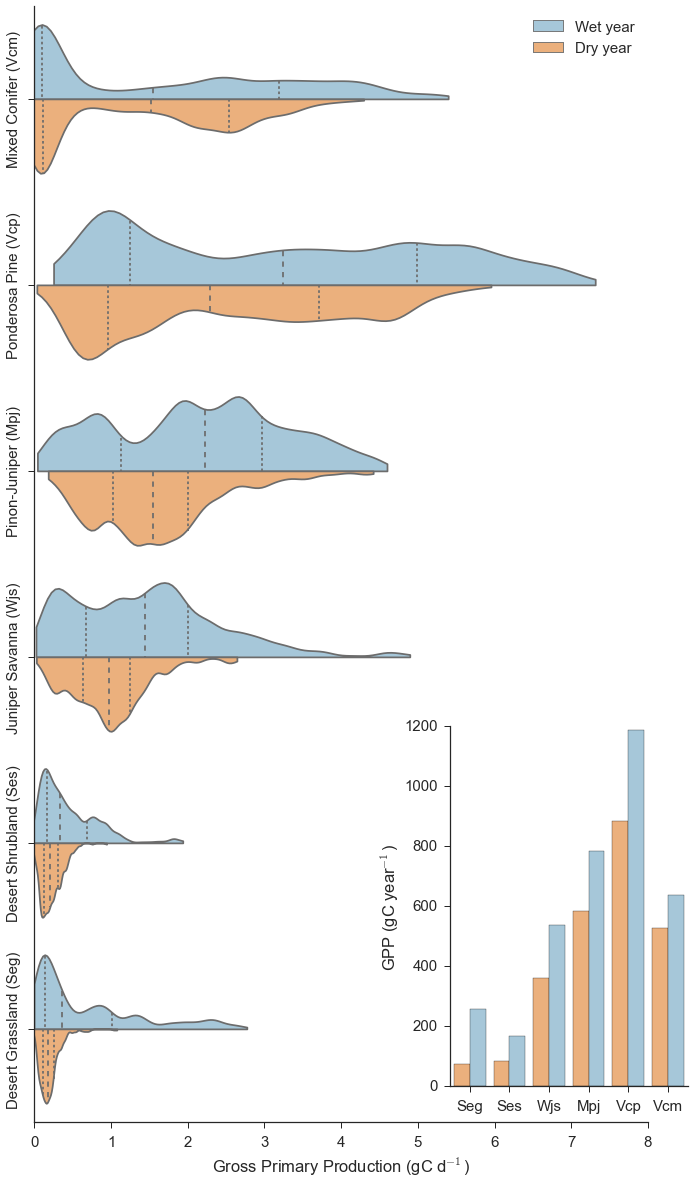

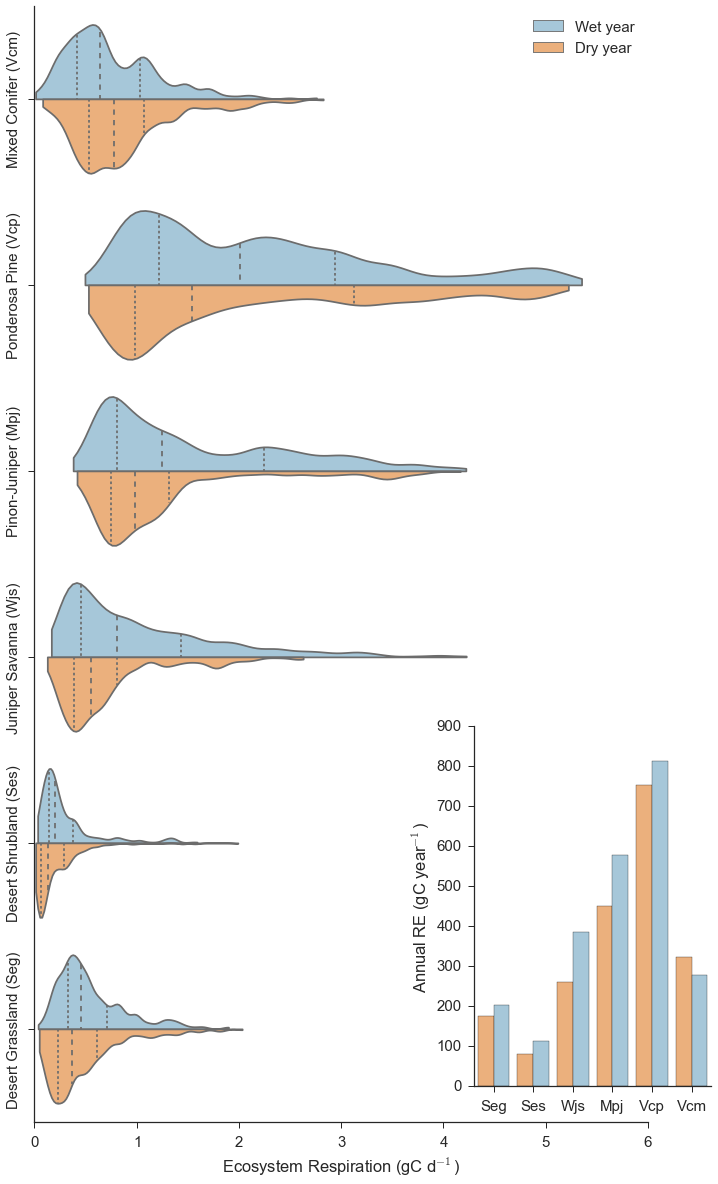

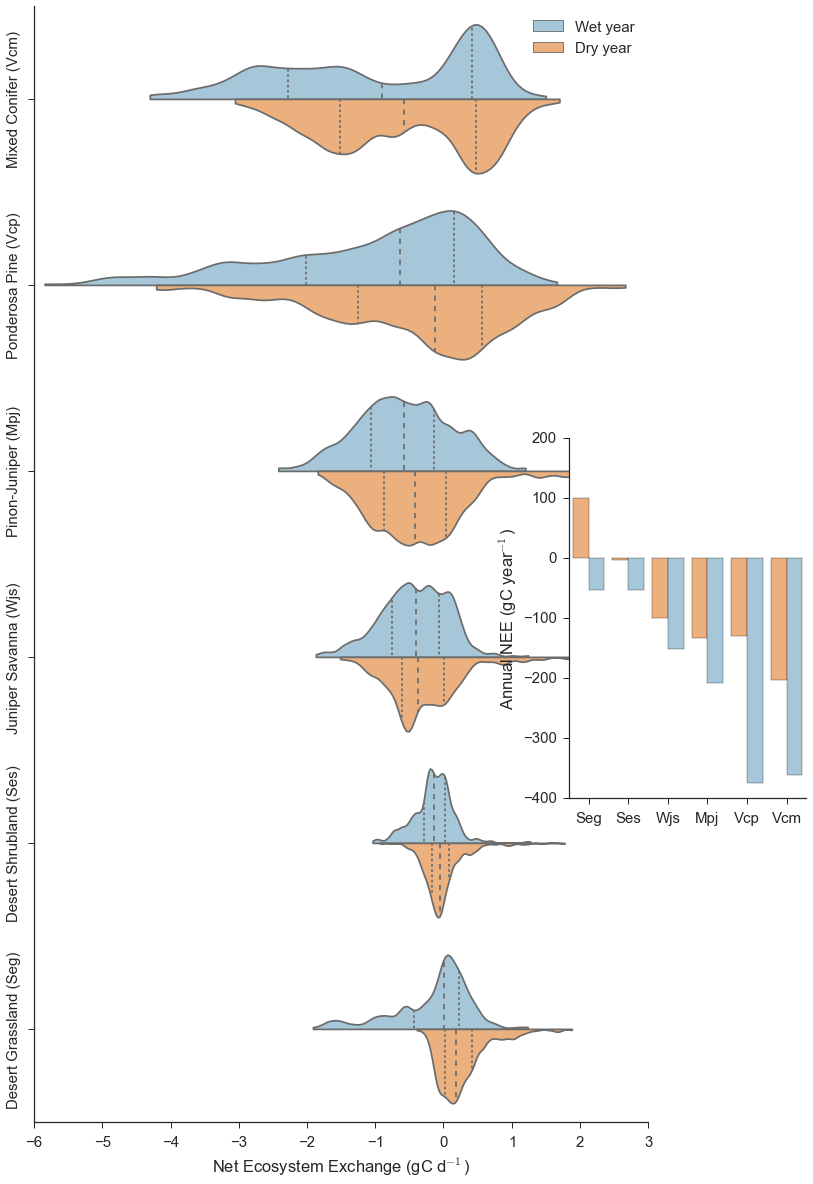

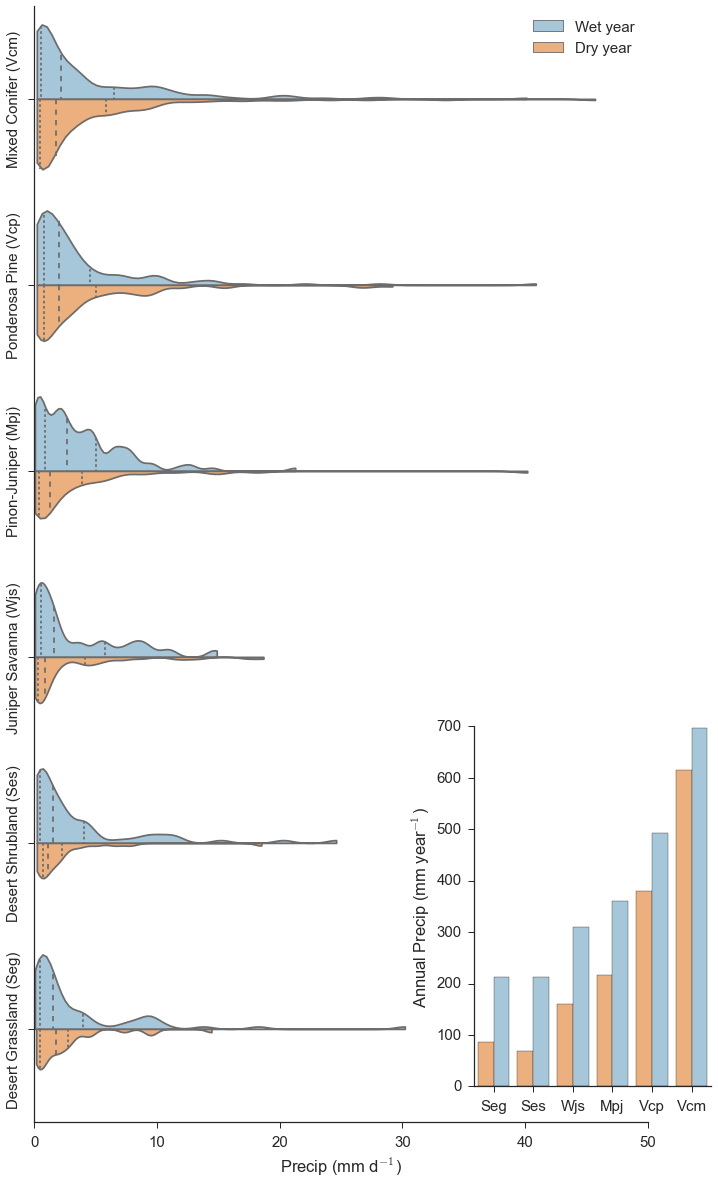

In [251]:
f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="GPP", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.65, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="GPP", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('GPP (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Gross Primary Production (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtGPP.tif')



f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="RECO", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.68, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="RECO", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual RE (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Ecosystem Respiration (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtRE.tif')



f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="FC_F", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.80, 0.35, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="FC_F", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual NEE (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Net Ecosystem Exchange (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtNEE.tif')




# Set days with no rain to NaN
highLow[highLow.P_F <= 0] = np.nan


f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="P_F", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.68, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="P_F", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual Precip (mm year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Precip (mm d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtPRECIP.tif')

In [252]:
fluxdf.groupby(['HY','SITE']).describe()

CO2        FC_F  Fc_F for J-S 2009         GPP  \
HY     SITE                                                                
2007.0 Mpj  count    0.000000    0.000000           0.000000    0.000000   
            mean          NaN         NaN                NaN         NaN   
            std           NaN         NaN                NaN         NaN   
            min           NaN         NaN                NaN         NaN   
            25%           NaN         NaN                NaN         NaN   
            50%           NaN         NaN                NaN         NaN   
            75%           NaN         NaN                NaN         NaN   
            max           NaN         NaN                NaN         NaN   
       Seg  count    0.000000    0.000000           0.000000    0.000000   
            mean          NaN         NaN                NaN         NaN   
            std           NaN         NaN                NaN         NaN   
            min           NaN         NaN                NaN         NaN   
            25%           NaN         NaN                NaN         NaN   
            50%           NaN         NaN                NaN         NaN   
            75%           NaN         NaN                NaN         NaN   
            max           NaN         NaN                NaN         NaN   
       Ses  count  288.000000  303.000000           0.000000  303.000000   
            mean   378.236476   -0.119371                NaN    0.577698   
            std     11.084531    0.351842                NaN    0.474833   
            min    360.606560   -1.176962                NaN    0.000000   
            25%    367.632560   -0.331100                NaN    0.186049   
            50%    377.237000   -0.143840                NaN    0.455187   
            75%    388.298162    0.077310                NaN    0.816197   
            max    405.821750    1.302197                NaN    2.453268   
       Vcm  count  298.000000  303.000000           0.000000  303.000000   
            mean   385.236909   -1.404510                NaN    2.145090   
            std      2.736212    1.331852                NaN    1.436634   
            min    376.389680   -4.162233                NaN    0.000000   
            25%    383.593347   -2.506444                NaN    0.326320   
            50%    385.552245   -1.647386                NaN    2.452164   
...                       ...         ...                ...         ...   
2016.0 Ses  std      4.058657    0.166272                NaN    0.060334   
            min    395.197750   -0.126452                NaN    0.025988   
            25%    399.461245    0.002791                NaN    0.073611   
            50%    401.190280    0.058413                NaN    0.095986   
            75%    404.226955    0.169469                NaN    0.128684   
            max    410.784680    0.670989                NaN    0.416841   
       Vcm  count   58.000000   61.000000           0.000000   61.000000   
            mean   404.181242    0.192049                NaN    0.399427   
            std      3.657721    0.289639                NaN    0.264964   
            min    398.886370   -0.381317                NaN    0.061928   
            25%    401.812125   -0.054062                NaN    0.185688   
            50%    403.485530    0.195961                NaN    0.305959   
            75%    406.148655    0.394561                NaN    0.594064   
            max    418.785470    0.831456                NaN    1.221057   
       Vcp  count   58.000000   61.000000           0.000000   61.000000   
            mean   405.511561    0.176488                NaN    1.537911   
            std      3.539508    0.745809                NaN    1.019957   
            min    400.609570   -1.165520                NaN    0.085499   
            25%    403.730485   -0.292043                NaN    0.573174   
            50%    405.343010    0.143201                NaN    1.549106  

In [305]:
diffsT

,Season,level_0,CO2,FC_F,Fc_F for J-S 2009,GPP,GPP for J-S 2009,GPP_accum,H2O,HY,...,VPD_F_min,WS,Zero,datenum,deep_swc_interp,doy,mid_swc_interp,month,shall_swc_interp,year
0,Monsoon,50,1273.50223,-21.715620,NaN,39.331043,NaN,NaN,-82.382456,-153.0,...,-0.402561,50.720681,NaN,NaN,NaN,0,NaN,0.0,NaN,-153
1,Spring,13,-107.82591,-19.100662,NaN,31.863123,NaN,NaN,197.104126,-61.0,...,-18.891164,-21.569707,NaN,NaN,NaN,0,NaN,0.0,NaN,-61
2,Winter,15,-7134.67685,-112.502415,NaN,110.329261,NaN,NaN,-16.687458,-151.0,...,-23.074264,-65.546130,NaN,NaN,NaN,0,NaN,0.0,NaN,-151


Seg
Ses
Wjs
Mpj
Vcp
Vcm


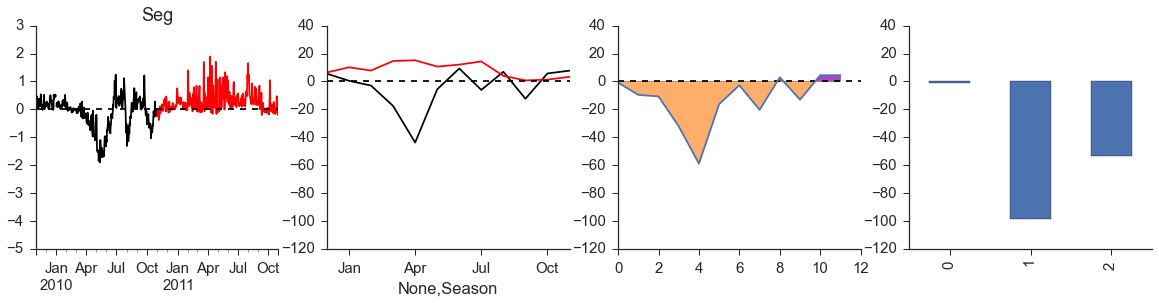

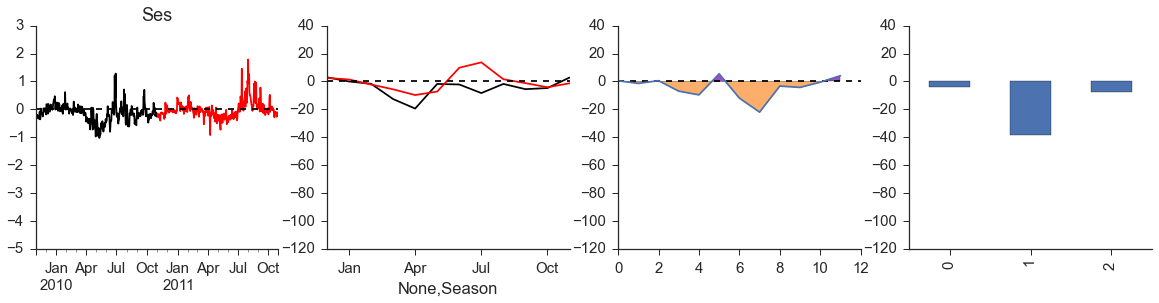

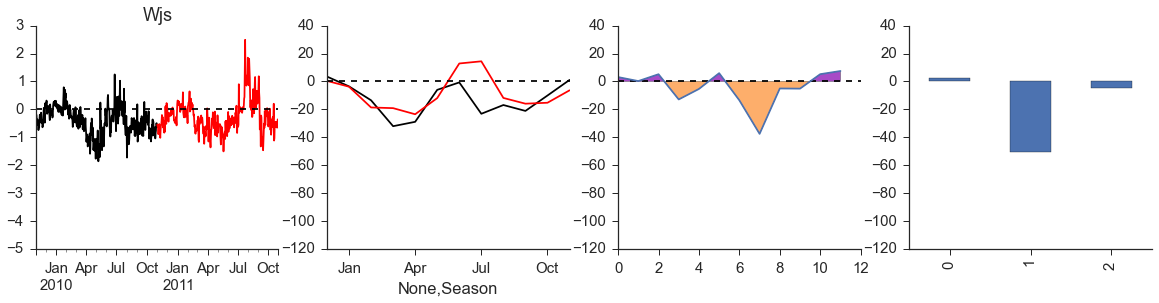

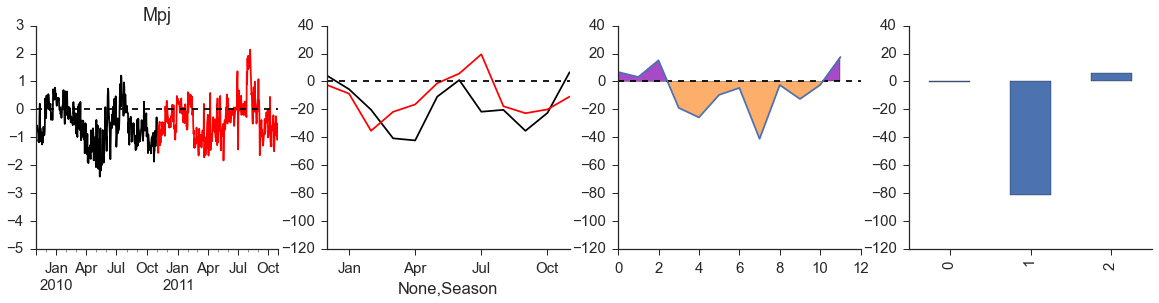

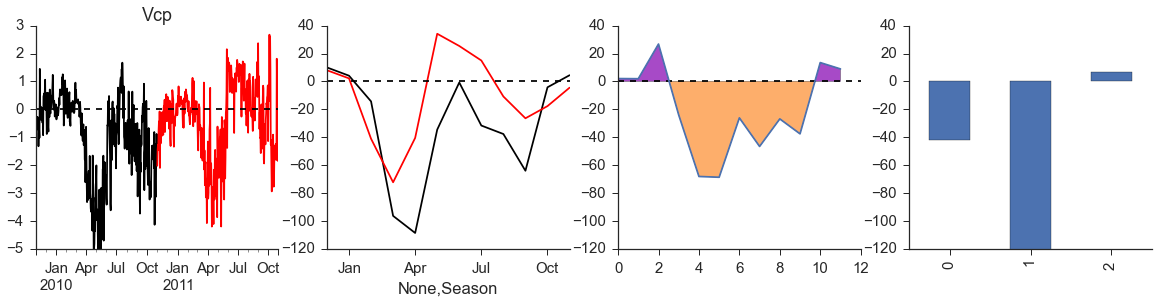

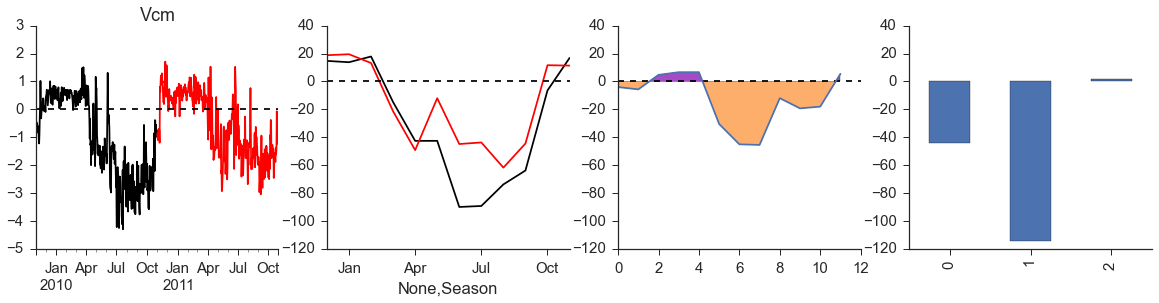

In [469]:
import warnings
warnings.filterwarnings('ignore')

idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    
    thisSite = highLow[highLow.SITE == site]
    thisSite['Season'] = 'Winter'
    wetYear = thisSite[thisSite.status == 'Wet year']
    dryYear = thisSite[thisSite.status == 'Dry year']
    print site

    wetYear.index = pd.date_range('2009-11-1','2010-10-31')
    dryYear.index = pd.date_range('2010-11-1','2011-10-31')
    
    wetYear['MonthName'] = 'Jan'
    wetYear.MonthName[wetYear.month == 1] = 'Nov'
    wetYear.MonthName[wetYear.month == 2] = 'Dec'
    wetYear.MonthName[wetYear.month == 3] = 'Jan'
    wetYear.MonthName[wetYear.month == 4] = 'Feb'
    wetYear.MonthName[wetYear.month == 5] = 'Mar'
    wetYear.MonthName[wetYear.month == 6] = 'Apr'
    wetYear.MonthName[wetYear.month == 7] = 'May'
    wetYear.MonthName[wetYear.month == 8] = 'Jun'
    wetYear.MonthName[wetYear.month == 9] = 'Jul'
    wetYear.MonthName[wetYear.month == 10] = 'Aug'
    wetYear.MonthName[wetYear.month == 11] = 'Sep'
    wetYear.MonthName[wetYear.month == 12] = 'Oct'
    wetYear.MonthName = wetYear['MonthName'].astype('category')
    wetYear['MonthName'].cat.reorder_categories(monthOrder)

    wetYear['hydMonth'] = 1
    wetYear.hydMonth[wetYear.MonthName == 'Nov'] = 1
    wetYear.hydMonth[wetYear.MonthName == 'Dec'] = 2
    wetYear.hydMonth[wetYear.MonthName == 'Jan'] = 3
    wetYear.hydMonth[wetYear.MonthName == 'Feb'] = 4
    wetYear.hydMonth[wetYear.MonthName == 'Mar'] = 5
    wetYear.hydMonth[wetYear.MonthName == 'Apr'] = 6
    wetYear.hydMonth[wetYear.MonthName == 'May'] = 7
    wetYear.hydMonth[wetYear.MonthName == 'Jun'] = 8
    wetYear.hydMonth[wetYear.MonthName == 'Jul'] = 9
    wetYear.hydMonth[wetYear.MonthName == 'Aug'] = 10
    wetYear.hydMonth[wetYear.MonthName == 'Sep'] = 11
    wetYear.hydMonth[wetYear.MonthName == 'Oct'] = 12

    dryYear['MonthName'] = 'Jan'
    dryYear['hydMonth'] = 1
    dryYear.MonthName[dryYear.month == 1] = 'Nov'
    dryYear.MonthName[dryYear.month == 2] = 'Dec'
    dryYear.MonthName[dryYear.month == 3] = 'Jan'
    dryYear.MonthName[dryYear.month == 4] = 'Feb'
    dryYear.MonthName[dryYear.month == 5] = 'Mar'
    dryYear.MonthName[dryYear.month == 6] = 'Apr'
    dryYear.MonthName[dryYear.month == 7] = 'May'
    dryYear.MonthName[dryYear.month == 8] = 'Jun'
    dryYear.MonthName[dryYear.month == 9] = 'Jul'
    dryYear.MonthName[dryYear.month == 10] = 'Aug'
    dryYear.MonthName[dryYear.month == 11] = 'Sep'
    dryYear.MonthName[dryYear.month == 12] = 'Oct'
    dryYear.MonthName = dryYear['MonthName'].astype('category')
    dryYear['MonthName'].cat.reorder_categories(monthOrder)

    dryYear.hydMonth[dryYear.MonthName == 'Nov'] = 1
    dryYear.hydMonth[dryYear.MonthName == 'Dec'] = 2
    dryYear.hydMonth[dryYear.MonthName == 'Jan'] = 3
    dryYear.hydMonth[dryYear.MonthName == 'Feb'] = 4
    dryYear.hydMonth[dryYear.MonthName == 'Mar'] = 5
    dryYear.hydMonth[dryYear.MonthName == 'Apr'] = 6
    dryYear.hydMonth[dryYear.MonthName == 'May'] = 7
    dryYear.hydMonth[dryYear.MonthName == 'Jun'] = 8
    dryYear.hydMonth[dryYear.MonthName == 'Jul'] = 9
    dryYear.hydMonth[dryYear.MonthName == 'Aug'] = 10
    dryYear.hydMonth[dryYear.MonthName == 'Sep'] = 11
    dryYear.hydMonth[dryYear.MonthName == 'Oct'] = 12

    dryYear['Season'] = 'Winter'
    dryYear.Season[dryYear.hydMonth < 5] ='Winter'
    dryYear.Season[(dryYear.hydMonth > 4) & (dryYear.hydMonth < 9)] ='Spring'
    dryYear.Season[dryYear.hydMonth > 8] ='Monsoon'

    wetYear['Season'] = 'Winter'
    wetYear.Season[wetYear.hydMonth < 5] ='Winter'
    wetYear.Season[(wetYear.hydMonth > 4) & (wetYear.hydMonth < 9)] ='Spring'
    wetYear.Season[wetYear.hydMonth > 8] ='Monsoon'  
    
    wetMonths = wetYear.groupby([wetYear.index.month, 'Season']).sum()
    dryMonths = dryYear.groupby([dryYear.index.month, 'Season']).sum()
    
    diff = wetMonths - dryMonths
    wetMonths['Zero'] = 0
    diff['Zero'] = 0
    diffS = diff.reset_index().groupby('Season').sum().reset_index()

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

    wetYear.FC_F.plot(ax = ax1, c = 'k')
    dryYear.FC_F.plot(ax = ax1, c = 'red')
    wetMonths.FC_F.plot(ax = ax2, c = 'k')
    dryMonths.FC_F.plot(ax = ax2, c = 'red')
    ax1.axhline(y=0, color = 'k', linestyle = '--')
    ax2.axhline(y=0, color = 'k', linestyle = '--')
    ax3.axhline(y=0, color = 'k', linestyle = '--')
    y2 = (wetMonths.FC_F - dryMonths.FC_F)
    
    y1 = wetMonths.Zero
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 <= y1, facecolor='#fdae6b', interpolate=True)
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 >= y1, facecolor='#a74ac7', interpolate=True)

    diffS.FC_F.plot(x = 'Season', kind = 'bar', ax = ax4, color = 'k')
    #ax4.set_xticklabels(['Monsoon','Spring','Winter'])
    ax3.plot(wetMonths.FC_F - dryMonths.FC_F)

    ax2.set_xticks([1,4,7,10])
    ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax1.set_title(site)
    
    #### Axes
    ax1.set_ylim([-5,3])
    ax2.set_ylim([-120,40])
    ax3.set_ylim([-120,40])
    ax4.set_ylim([-120,40])
    
    #### DF creation for gradient wide averaging
    if idx == 0:
        diffDF = pd.DataFrame(dict(WD_Diff = y2, SITE = site))
    else:
        diff = pd.DataFrame(dict(WD_Diff = y2, SITE = site))
        diffDF = pd.concat([diffDF, diff])
    sns.despine()
    plt.savefig('draftDroughts_' + site + '.tif')
    idx = idx + 1
    


In [472]:
highLow['AREA_C'] = 9000000000
highLow.AREA_C[highLow.SITE == 'Vcp'] = 20000000000
highLow.AREA_C[highLow.SITE == 'Mpj'] = 50000000000
highLow.AREA_C[highLow.SITE == 'Wjs'] = 10000000000
highLow.AREA_C[highLow.SITE == 'Ses'] = 80000000000
highLow.AREA_C[highLow.SITE == 'Seg'] = 125400000000
highLow['weightedFC'] = highLow.FC_F * highLow.AREA_C / 10**12
highLow['weightedGPP'] = highLow.GPP * highLow.AREA_C / 10**12
highLow['weightedRE'] = highLow.RECO * highLow.AREA_C / 10**12

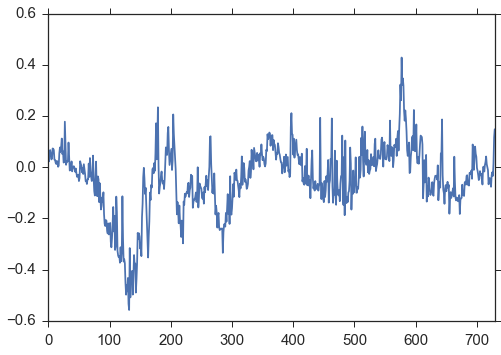

In [501]:
weightedSum = highLow.groupby(['HY','doy','month']).sum().reset_index()
weightedSum.weightedFC.plot()
weightedSum.index = pd.date_range('2009-11-1','2011-10-31')

In [474]:
wetYear = weightedSum[weightedSum.HY == 2010] 
dryYear = weightedSum[weightedSum.HY == 2011] 

wetYear['MonthName'] = 'Jan'
wetYear.MonthName[wetYear.month == 1] = 'Nov'
wetYear.MonthName[wetYear.month == 2] = 'Dec'
wetYear.MonthName[wetYear.month == 3] = 'Jan'
wetYear.MonthName[wetYear.month == 4] = 'Feb'
wetYear.MonthName[wetYear.month == 5] = 'Mar'
wetYear.MonthName[wetYear.month == 6] = 'Apr'
wetYear.MonthName[wetYear.month == 7] = 'May'
wetYear.MonthName[wetYear.month == 8] = 'Jun'
wetYear.MonthName[wetYear.month == 9] = 'Jul'
wetYear.MonthName[wetYear.month == 10] = 'Aug'
wetYear.MonthName[wetYear.month == 11] = 'Sep'
wetYear.MonthName[wetYear.month == 12] = 'Oct'
wetYear.MonthName = wetYear['MonthName'].astype('category')
wetYear['MonthName'].cat.reorder_categories(monthOrder)

wetYear['hydMonth'] = 1
wetYear.hydMonth[wetYear.MonthName == 'Nov'] = 1
wetYear.hydMonth[wetYear.MonthName == 'Dec'] = 2
wetYear.hydMonth[wetYear.MonthName == 'Jan'] = 3
wetYear.hydMonth[wetYear.MonthName == 'Feb'] = 4
wetYear.hydMonth[wetYear.MonthName == 'Mar'] = 5
wetYear.hydMonth[wetYear.MonthName == 'Apr'] = 6
wetYear.hydMonth[wetYear.MonthName == 'May'] = 7
wetYear.hydMonth[wetYear.MonthName == 'Jun'] = 8
wetYear.hydMonth[wetYear.MonthName == 'Jul'] = 9
wetYear.hydMonth[wetYear.MonthName == 'Aug'] = 10
wetYear.hydMonth[wetYear.MonthName == 'Sep'] = 11
wetYear.hydMonth[wetYear.MonthName == 'Oct'] = 12

dryYear['MonthName'] = 'Jan'
dryYear['hydMonth'] = 1
dryYear.MonthName[dryYear.month == 1] = 'Nov'
dryYear.MonthName[dryYear.month == 2] = 'Dec'
dryYear.MonthName[dryYear.month == 3] = 'Jan'
dryYear.MonthName[dryYear.month == 4] = 'Feb'
dryYear.MonthName[dryYear.month == 5] = 'Mar'
dryYear.MonthName[dryYear.month == 6] = 'Apr'
dryYear.MonthName[dryYear.month == 7] = 'May'
dryYear.MonthName[dryYear.month == 8] = 'Jun'
dryYear.MonthName[dryYear.month == 9] = 'Jul'
dryYear.MonthName[dryYear.month == 10] = 'Aug'
dryYear.MonthName[dryYear.month == 11] = 'Sep'
dryYear.MonthName[dryYear.month == 12] = 'Oct'
dryYear.MonthName = dryYear['MonthName'].astype('category')
dryYear['MonthName'].cat.reorder_categories(monthOrder)

dryYear.hydMonth[dryYear.MonthName == 'Nov'] = 1
dryYear.hydMonth[dryYear.MonthName == 'Dec'] = 2
dryYear.hydMonth[dryYear.MonthName == 'Jan'] = 3
dryYear.hydMonth[dryYear.MonthName == 'Feb'] = 4
dryYear.hydMonth[dryYear.MonthName == 'Mar'] = 5
dryYear.hydMonth[dryYear.MonthName == 'Apr'] = 6
dryYear.hydMonth[dryYear.MonthName == 'May'] = 7
dryYear.hydMonth[dryYear.MonthName == 'Jun'] = 8
dryYear.hydMonth[dryYear.MonthName == 'Jul'] = 9
dryYear.hydMonth[dryYear.MonthName == 'Aug'] = 10
dryYear.hydMonth[dryYear.MonthName == 'Sep'] = 11
dryYear.hydMonth[dryYear.MonthName == 'Oct'] = 12

dryYear['Season'] = 'Winter'
dryYear.Season[dryYear.hydMonth < 5] ='Winter'
dryYear.Season[(dryYear.hydMonth > 4) & (dryYear.hydMonth < 9)] ='Spring'
dryYear.Season[dryYear.hydMonth > 8] ='Monsoon'

wetYear['Season'] = 'Winter'
wetYear.Season[wetYear.hydMonth < 5] ='Winter'
wetYear.Season[(wetYear.hydMonth > 4) & (wetYear.hydMonth < 9)] ='Spring'
wetYear.Season[wetYear.hydMonth > 8] ='Monsoon'

In [502]:
print wetSumSeas.weightedFC
print drySumSeas.weightedFC

Season
Monsoon    -7.002487
Spring    -18.548264
Winter     -7.990340
Name: weightedFC, dtype: float64
Season
Monsoon   -5.279612
Spring     6.656881
Winter    -1.077636
Name: weightedFC, dtype: float64


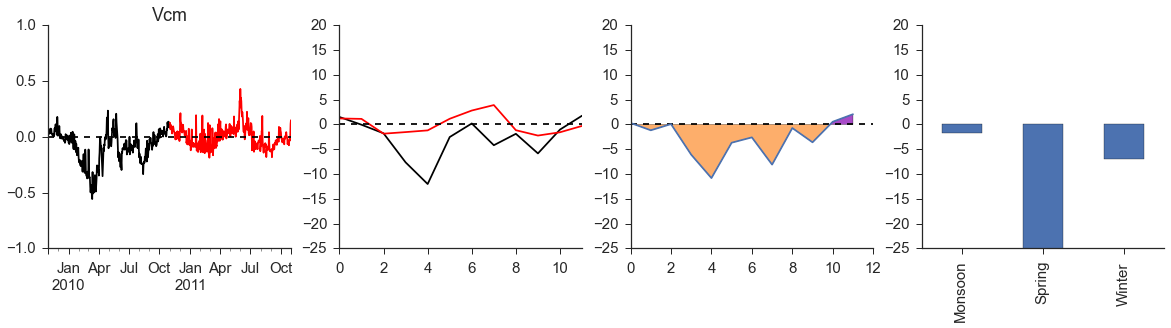

In [503]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()

wetYear.weightedFC.plot(ax = ax1, c = 'k')
dryYear.weightedFC.plot(ax = ax1, c = 'red')
wetSum.weightedFC.plot(ax = ax2, c = 'k')
drySum.weightedFC.plot(ax = ax2, c = 'red')
ax1.axhline(y=0, color = 'k', linestyle = '--')
ax2.axhline(y=0, color = 'k', linestyle = '--')
ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (wetSum.weightedFC - drySum.weightedFC)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='#fdae6b', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#a74ac7', interpolate=True)

diffs = wetSumSeas.weightedFC - drySumSeas.weightedFC
diffs.plot(x = 'Season', kind = 'bar', ax = ax4)
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(wetSum.weightedFC - drySum.weightedFC)

#ax2.set_xticks([1,4,7,10])
#ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
ax1.set_title(site)

#### Axes
ax1.set_ylim([-1,1])
ax2.set_ylim([-25,20])
ax3.set_ylim([-25,20])
ax4.set_ylim([-25,20])

sns.despine()

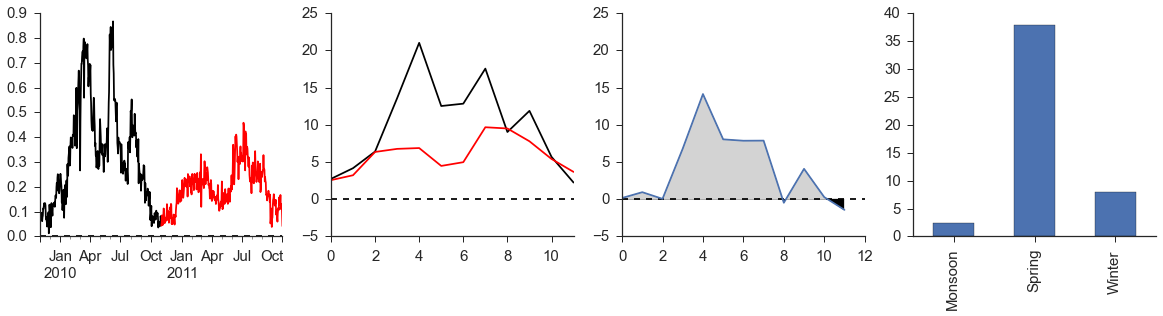

In [504]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()

wetYear.weightedGPP.plot(ax = ax1, c = 'k')
dryYear.weightedGPP.plot(ax = ax1, c = 'red')
wetSum.weightedGPP.plot(ax = ax2, c = 'k')
drySum.weightedGPP.plot(ax = ax2, c = 'red')
ax1.axhline(y=0, color = 'k', linestyle = '--')
ax2.axhline(y=0, color = 'k', linestyle = '--')
ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (wetSum.weightedGPP - drySum.weightedGPP)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='k', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)

diffs = wetSumSeas.weightedGPP - drySumSeas.weightedGPP
diffs.plot(x = 'Season', kind = 'bar', ax = ax4)
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(wetSum.weightedGPP - drySum.weightedGPP)

#ax2.set_xticks([1,4,7,10])
#ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
#ax1.set_title(site)

#### Axes
#ax1.set_ylim([-1,1])
ax2.set_ylim([-5,25])
ax3.set_ylim([-5,25])
#ax4.set_ylim([-25,20])

sns.despine()

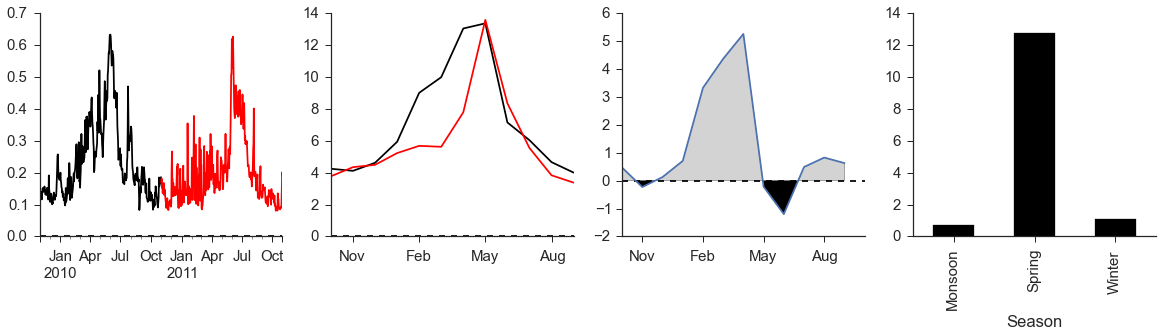

In [508]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 4))

wetSum = wetYear.groupby(['HY','hydMonth']).sum().reset_index()
wetSumSeas = wetYear.groupby(['Season']).sum().reset_index()

drySum = dryYear.groupby(['HY','hydMonth']).sum().reset_index()
drySumSeas = dryYear.groupby(['Season']).sum().reset_index()


wetYear.weightedRE.plot(ax = ax1, c = 'k')
dryYear.weightedRE.plot(ax = ax1, c = 'red')
wetSum.weightedRE.plot(ax = ax2, c = 'k')
drySum.weightedRE.plot(ax = ax2, c = 'red')
ax1.axhline(y=0, color = 'k', linestyle = '--')
ax2.axhline(y=0, color = 'k', linestyle = '--')
ax3.axhline(y=0, color = 'k', linestyle = '--')
y2 = (wetSum.weightedRE - drySum.weightedRE)

y1 = wetMonths.Zero
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 <= y1, facecolor='k', interpolate=True)
ax3.fill_between(np.arange(0,12,1), y1, y2, 
                 where= y2 >= y1, facecolor='#D3D3D3', interpolate=True)

diffs = wetSumSeas.weightedRE - drySumSeas.weightedRE
diffs.plot(x = 'Season', kind = 'bar', ax = ax4, color = 'k')
ax4.set_xticklabels(['Monsoon','Spring','Winter'])
ax3.plot(wetSum.weightedRE - drySum.weightedRE)

ax2.set_xticks([1,4,7,10])
ax2.set_xticklabels(['Nov','Feb','May','Aug'])
ax3.set_xticks([1,4,7,10])
ax3.set_xticklabels(['Nov','Feb','May','Aug'])

#ax1.set_title(site)

#### Axes
#ax1.set_ylim([-1,1])
#ax2.set_ylim([-5,25])
#ax3.set_ylim([-5,25])
#ax4.set_ylim([-25,20])

sns.despine()